In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SLCP experiment

In [4]:
from simulators import SLCP
from datasets import LTEDataset
from models import Flatten, MLP, NRE
from criterions import WeightedLoss, RELoss
from samplers import TractableSampler, NRESampler
from histograms import pairhist, corner

## Simulator 

In [5]:
simulator = SLCP().to(device)
simulator.sample()

(tensor([0.4802, 1.7161, 0.7468, 1.7140, 0.2274], device='cuda:0'),
 tensor([[ 0.5516, -5.4555],
         [ 1.0107,  1.1619],
         [ 0.0215,  3.4082],
         [-0.1603,  5.1698]], device='cuda:0'))

In [6]:
trainset = LTEDataset(simulator)

## Model

In [7]:
encoder = Flatten((4, 2)).to(device)
model = NRE(5, 8, num_layers=10, hidden_size=256, activation=nn.SELU).to(device)
criterion = RELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1e-1, patience=5, threshold=1e-2, verbose=True)

### Train

In [8]:
model.train()

epoch = 0
epoch_size = 256

losses = []

for thetas, xs, mask in trainset:
    ratios = model(thetas, encoder(xs))
    loss = criterion(ratios, mask)

    losses.append(loss.tolist())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    if len(losses) == epoch_size:
        losses = torch.tensor(losses)

        print(f'{epoch}: {losses.mean()} +- {losses.std()}')
        scheduler.step(losses.mean())

        epoch += 1
        losses = []

        if optimizer.param_groups[0]['lr'] < 1e-6:
            break

torch.save(model.state_dict(), 'nre.pth')

0: 0.5712252259254456 +- 0.17501911520957947
1: 0.4540232717990875 +- 0.12287349998950958
2: 0.41289833188056946 +- 0.16404695808887482
3: 0.3835974931716919 +- 0.1451181024312973
4: 0.3439062237739563 +- 0.11820940673351288
5: 0.3138660490512848 +- 0.09773766994476318
6: 0.2825908362865448 +- 0.07299414277076721
7: 0.25167325139045715 +- 0.05938350781798363
8: 0.21211516857147217 +- 0.0514247752726078
9: 0.19323605298995972 +- 0.04045380279421806
10: 0.175162672996521 +- 0.04226627200841904
11: 0.15723884105682373 +- 0.04499209299683571
12: 0.14432762563228607 +- 0.04124405235052109
13: 0.1280556321144104 +- 0.04023318365216255
14: 0.12019441276788712 +- 0.037896353751420975
15: 0.11195402592420578 +- 0.036954984068870544
16: 0.10748429596424103 +- 0.0358896441757679
17: 0.10179895907640457 +- 0.033143457025289536
18: 0.10117160528898239 +- 0.03580433875322342
19: 0.10046592354774475 +- 0.033231984823942184
20: 0.0971188172698021 +- 0.036432888358831406
21: 0.09667409211397171 +- 0.03

In [9]:
model.load_state_dict(torch.load('nre.pth', map_location=device))

<All keys matched successfully>

## Metropolis-Hastings

In [10]:
labels = [f'$\\theta_{{{i}}}$' for i in range(1, 6)]

low = simulator.low.cpu().numpy()
high = simulator.high.cpu().numpy()

In [11]:
theta_star = torch.tensor([0.7, -2.9, -1., -0.9,  0.6]).to(device)
x_star = torch.tensor([
    [-0.48406151, -3.13977371],
    [-0.43098274, -3.50238278],
    [-0.03512463, -2.87554796],
    [ 1.43279532, -2.80650507]
]).to(device)

In [12]:
x_star = x_star.expand((2 ** 12,) + x_star.shape)

### Likelihood

In [13]:
sampler = TractableSampler(simulator, x_star, sigma=0.1)
hists = pairhist(sampler(4096), low, high, bins=60, normed=True, bounded=True)

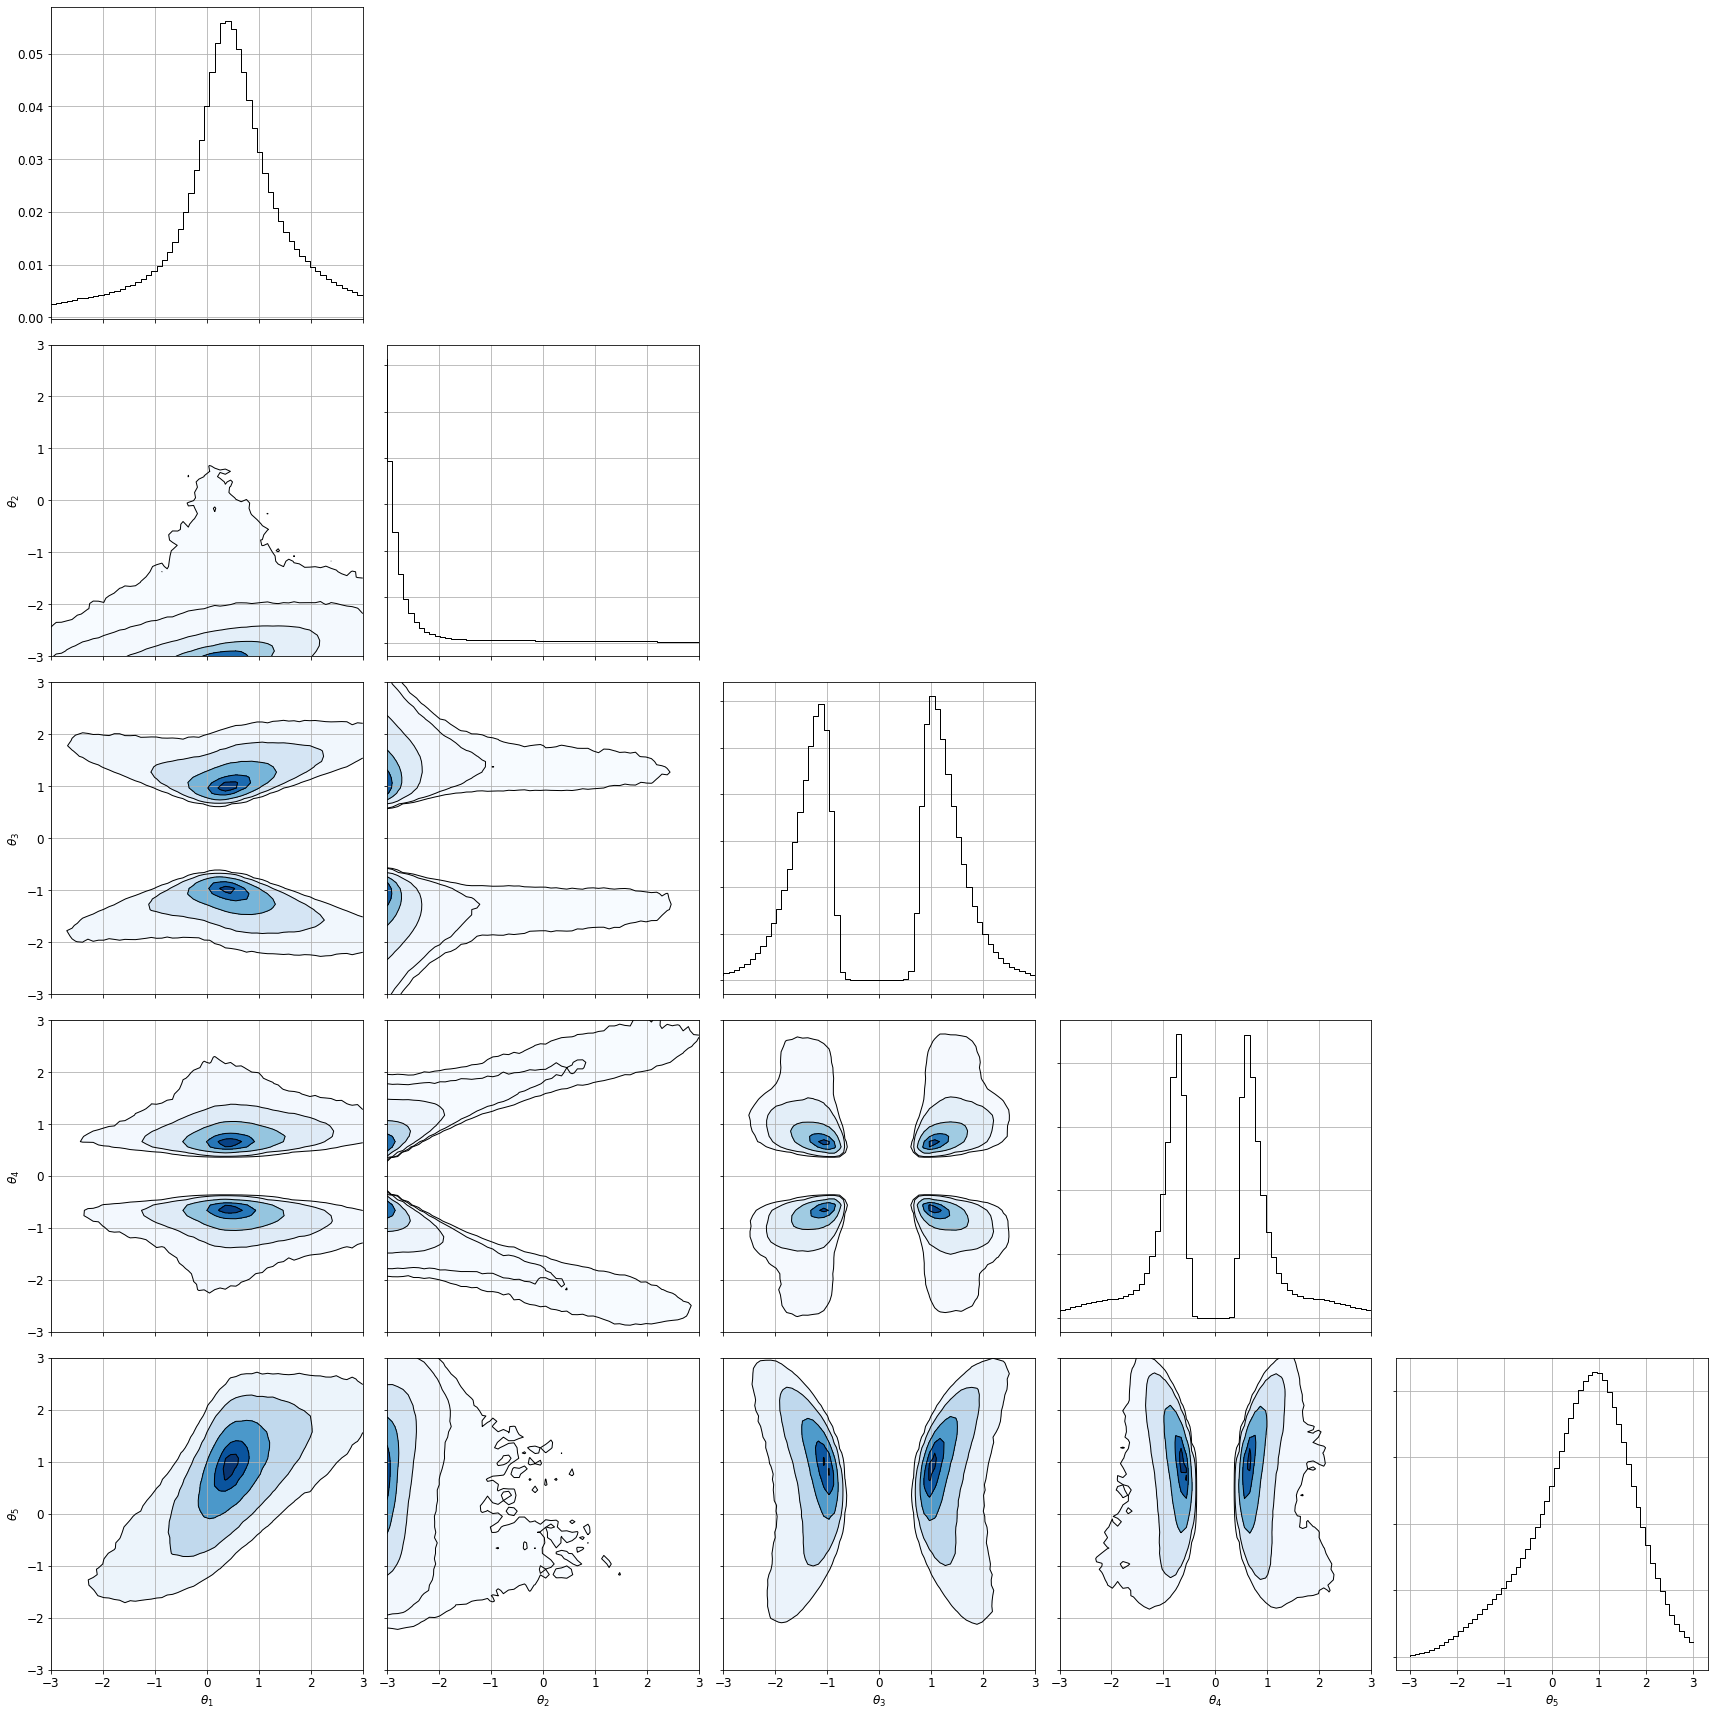

In [14]:
fig = corner(hists, low, high, labels=labels)

### NRE

In [15]:
model.eval()
z_star = encoder(x_star)

In [16]:
sampler = NRESampler(simulator.prior, model, z_star, sigma=0.1)
hists = pairhist(sampler(4096), low, high, bins=60, normed=True, bounded=True)

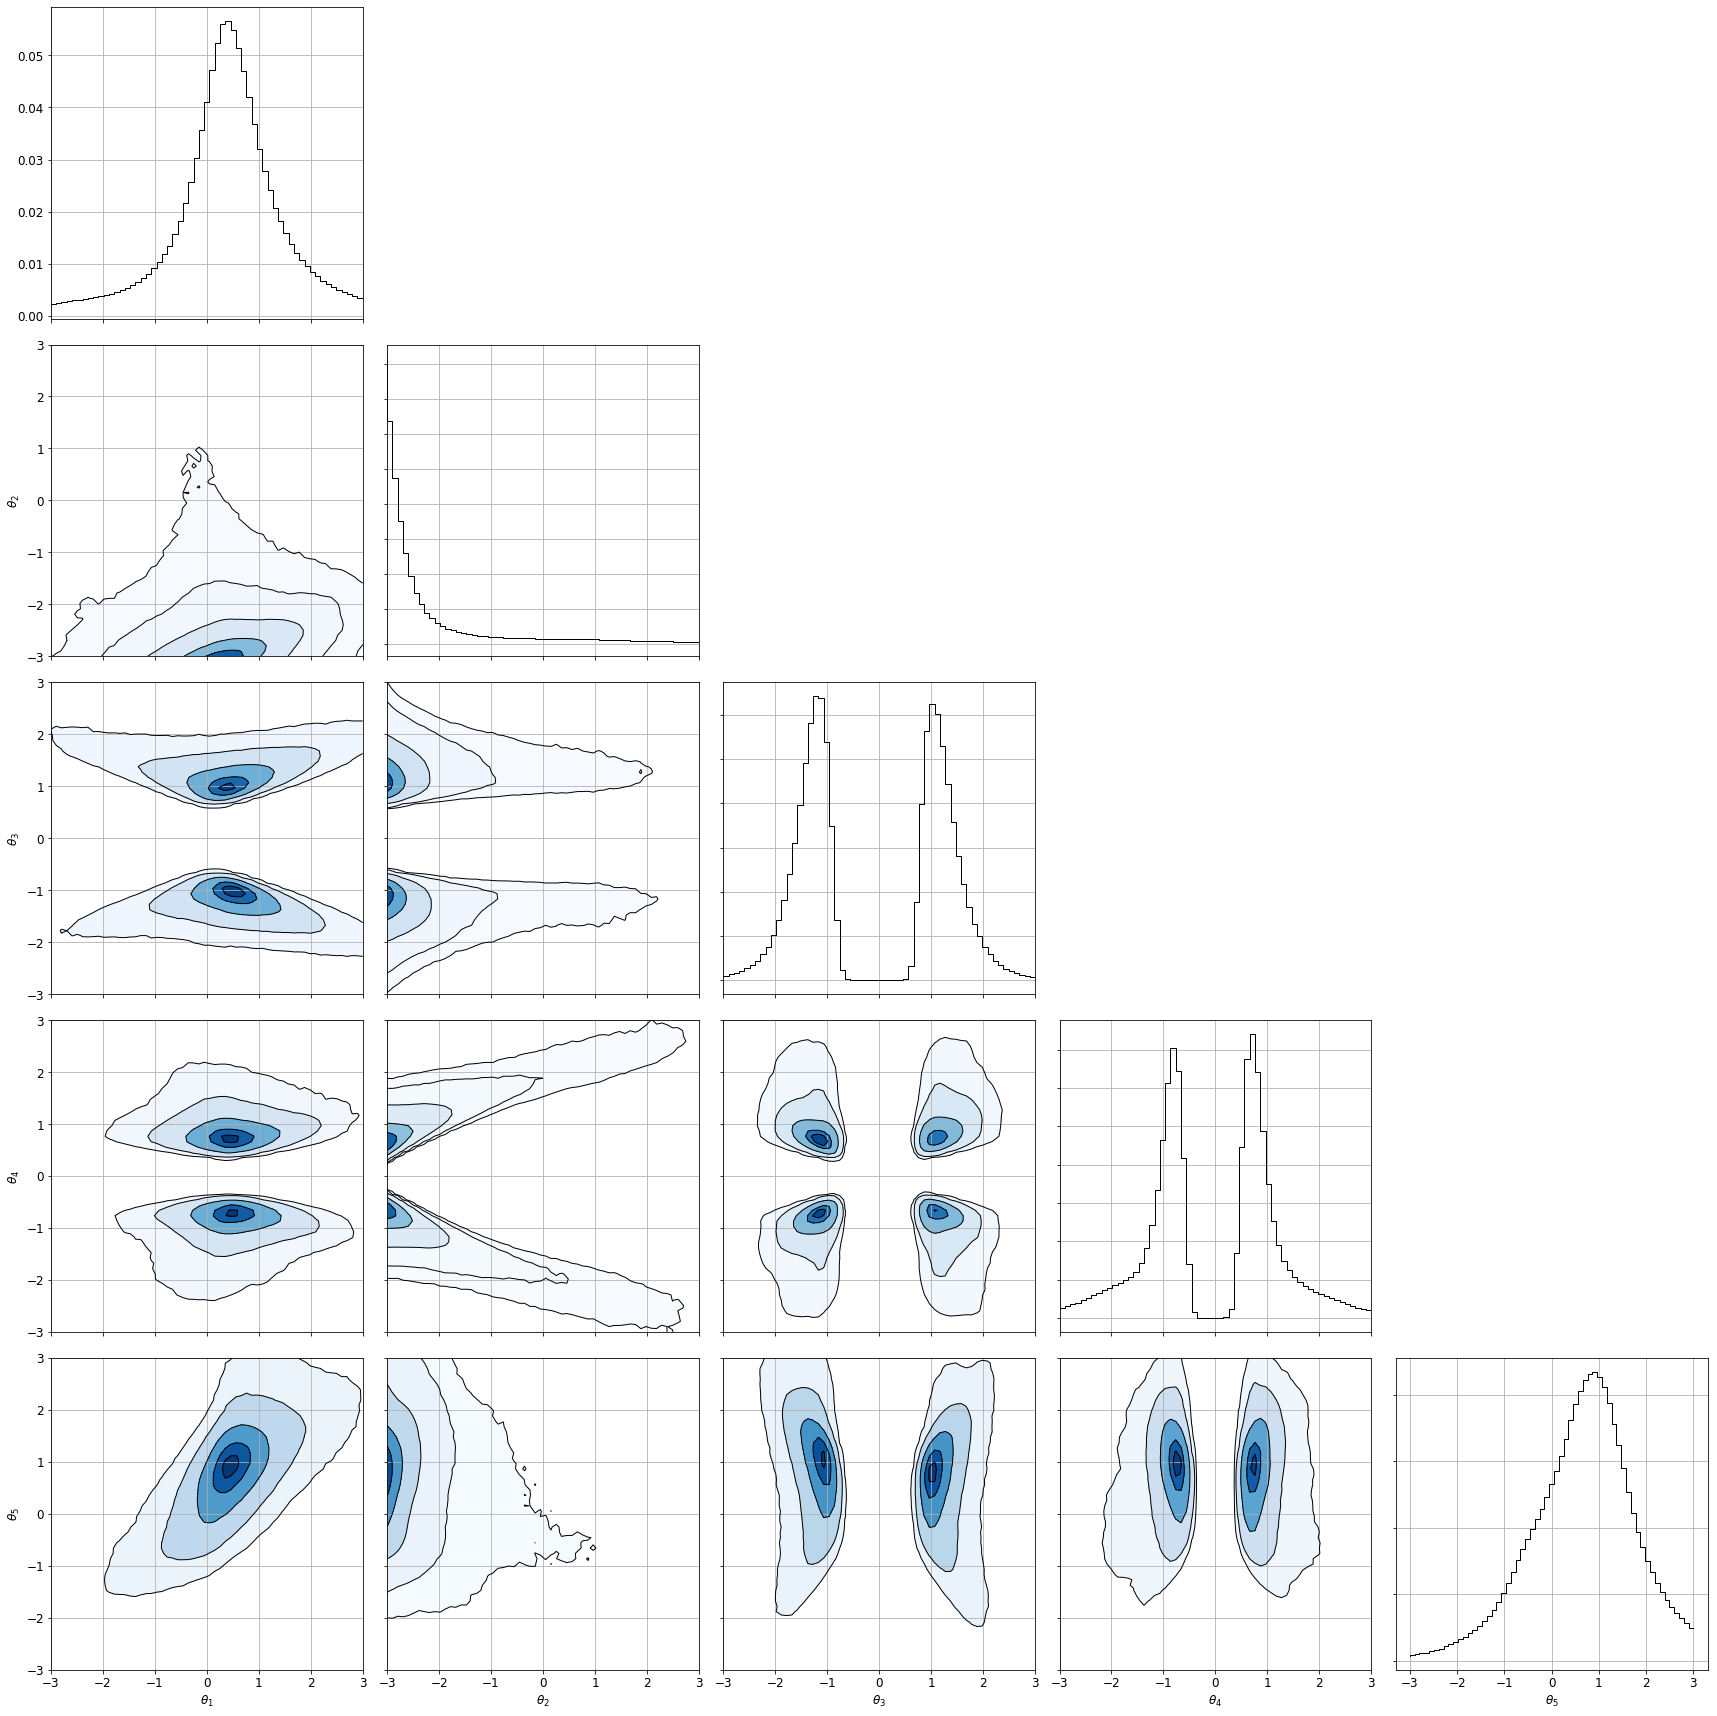

In [17]:
fig = corner(hists, low, high, labels=labels)